In [94]:
import torch
import torchvision
from torchvision.transforms import functional as vision_F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from utils.networks import DecoderNoInput, DecoderRNN
from utils.transforms import (
    apply_transformations,
    get_transforms_list,
    split_interval,
    custom_crop
)

import matplotlib.pyplot as plt



cifar10_dataset = torchvision.datasets.CIFAR10('dataset', download=True)


class MyDatset(Dataset):
    def __init__(self, train_dataset):
        self.train_dataset = train_dataset
        self.to_tensor = transforms.ToTensor()

    def __len__(self,):
        return len(self.train_dataset)
    
    def __getitem__(self, i):
        img, y = self.train_dataset[i][0], self.train_dataset[i][1]
        x = self.to_tensor(img)
        return x, y
    
    
dataset = MyDatset(cifar10_dataset)
img = dataset[4][0]

ImportError: cannot import name 'custom_crop' from 'utils.transforms' (/home/nazim/Script/RL_contrastive/utils/transforms.py)

In [5]:
def clip(n, min, max):
    if n > max:
        return max
    elif n < min:
        return min
    return n

def custom_crop(img, position, scale):
    """_summary_

    Args:
        position (_type_): in 
            [0, 1, 2,
             3, 4, 5,
             6, 7, 8]
        target_area (float): in [0.08, 1.]
    """

    position = clip(position, 0, 8)
    
    ratio = (3.0 / 4.0, 4.0 / 3.0)
    
    *_, height, width = img.shape
    area = height * width

    target_area = area * scale
    log_ratio = torch.log(torch.tensor(ratio))
    aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

    
    w = int(round((target_area * aspect_ratio)**0.5))
    h = int(round((target_area / aspect_ratio)**0.5))
    h = clip(h, 0, height)
    w = clip(w, 0, width)
    
    i, j = height * (position//3)/3, width * (position%3)/3
    i_noise = torch.empty(1).uniform_(0, height/3).item()
    j_noise = torch.empty(1).uniform_(0, width/3).item()    
    i, j = int(round(i + i_noise)), int(round(j + j_noise))
    
    if i + h > height:
        i = height - h
    if j + w > width:
        j = width - w 
    
    return vision_F.resized_crop(img, i, j, h, w, size=(height, width), antialias="warn")
    

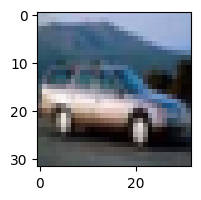

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(img.permute(1,2,0))
plt.show()

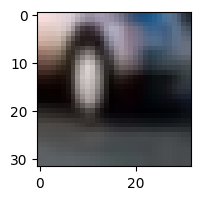

In [30]:
cropped_img = custom_crop(
    img=img, 
    position=5, 
    scale=0.2
)

plt.figure(figsize=(2,2))
plt.imshow(cropped_img.permute(1,2,0))
plt.show()

In [633]:
split_interval(0.2, 1, 10)

[0.2, 0.289, 0.378, 0.467, 0.556, 0.644, 0.733, 0.822, 0.911, 1.0]

---

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torchvision.models import resnet18, resnet50
from itertools import permutations

In [81]:
class DecoderRNN(nn.Module):
    def __init__(self,
            num_transforms,
            num_discrete_magnitude,
            device
            ):
        super().__init__()
    
        self.num_transforms = num_transforms
        self.num_discrete_magnitude = num_discrete_magnitude
        self.seq_length = num_transforms
        self.device = device
        
        self.permutations = torch.tensor(
            list(permutations(range(4)))
            ).to(device)
        
        self.num_transforms_permutations = len(self.permutations)
        self.num_actions = num_transforms * num_discrete_magnitude
        
        self.output_dim_per_view = (
            # Crop (Position[10], Area[10]):
            num_discrete_magnitude + num_discrete_magnitude + \
            # Color (4*magnitude[10], permutations):
            4 * num_discrete_magnitude + self.num_transforms_permutations + \
            # Gray (Porba[10]):
            num_discrete_magnitude + \
            # Gaussian blur (Sigma[10], Proba[10]):
            num_discrete_magnitude + num_discrete_magnitude
        )
        
        self.model = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * self.output_dim_per_view)
        )
        
        
    def forward(self, x, old_action_index=None):
        
        *leading_dim, input_dim = x.shape                        
        output = self.model(x)
        
        D = self.num_discrete_magnitude
        crop_position_offset = 0
        crop_area_offset = crop_position_offset + 2*D
        color_magnitude_offset = crop_area_offset + 2*D
        color_permutation_offset = color_magnitude_offset + 2*(4*D)
        gray_proba_offset = color_permutation_offset + 2*self.num_transforms_permutations
        blur_sigma_offset = gray_proba_offset + 2*D
        blur_proba_offset = blur_sigma_offset + 2*D
                
        
        crop_position_logits = output[:, :crop_area_offset]
        crop_area_logits = output[:, crop_area_offset:color_magnitude_offset]
        color_magnitude_logits = output[:, color_magnitude_offset:color_permutation_offset]
        color_permutation_logits = output[:, color_permutation_offset:gray_proba_offset]
        gray_proba_logits = output[:, gray_proba_offset:blur_sigma_offset]
        blur_sigma_logits = output[:, blur_sigma_offset:blur_proba_offset]
        blur_proba_logits = output[:, blur_proba_offset:]

        
        crop_position_logits = crop_position_logits.reshape(*leading_dim, 2, D)
        crop_area_logits = crop_area_logits.reshape(*leading_dim, 2, D)
        color_magnitude_logits = color_magnitude_logits.reshape(*leading_dim, 2, 4, D)
        color_permutation_logits = color_permutation_logits.reshape(*leading_dim, 2, self.num_transforms_permutations)
        gray_proba_logits = gray_proba_logits.reshape(*leading_dim, 2, D)
        blur_sigma_logits = blur_sigma_logits.reshape(*leading_dim, 2, D)
        blur_proba_logits = blur_proba_logits.reshape(*leading_dim, 2, D)
        
        
        crop_position_dist = torch.distributions.Categorical(logits=crop_position_logits)
        crop_area_dist = torch.distributions.Categorical(logits=crop_area_logits)
        color_magnitude_dist = torch.distributions.Categorical(logits=color_magnitude_logits)
        color_permutation_dist = torch.distributions.Categorical(logits=color_permutation_logits)
        gray_proba_dist = torch.distributions.Categorical(logits=gray_proba_logits)
        blur_sigma_dist = torch.distributions.Categorical(logits=blur_sigma_logits)
        blur_proba_dist = torch.distributions.Categorical(logits=blur_proba_logits)
                
        
        if old_action_index is None:
            crop_position_index = crop_position_dist.sample()
            crop_area_index = crop_area_dist.sample()
            color_magnitude_index = color_magnitude_dist.sample()
            color_permutation_index = color_permutation_dist.sample()
            gray_proba_index = gray_proba_dist.sample()
            blur_sigma_index = blur_sigma_dist.sample()
            blur_proba_index = blur_proba_dist.sample()
        else:
            crop_position_index = old_action_index[..., 0]
            crop_area_index = old_action_index[..., 1]
            color_magnitude_index = old_action_index[..., 2:6]
            color_permutation_index = old_action_index[..., 6]
            gray_proba_index = old_action_index[..., 7]
            blur_sigma_index = old_action_index[..., 8]
            blur_proba_index = old_action_index[..., 9]
        
        
        crop_position_log_p = F.log_softmax(crop_position_logits, dim=-1).gather(-1, crop_position_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)
        crop_area_log_p = F.log_softmax(crop_area_logits, dim=-1).gather(-1, crop_area_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)
        color_magnitude_log_p = F.log_softmax(color_magnitude_logits, dim=-1).gather(-1, color_magnitude_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)
        color_permutation_log_p = F.log_softmax(color_permutation_logits, dim=-1).gather(-1, color_permutation_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)
        gray_proba_log_p = F.log_softmax(gray_proba_logits, dim=-1).gather(-1, gray_proba_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)
        blur_sigma_log_p = F.log_softmax(blur_sigma_logits, dim=-1).gather(-1, blur_sigma_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)
        blur_proba_log_p = F.log_softmax(blur_proba_logits, dim=-1).gather(-1, blur_proba_index.unsqueeze(-1)).reshape(*leading_dim, -1).sum(-1, keepdim=True)


        log_p = (crop_position_log_p + crop_area_log_p) + (color_magnitude_log_p + color_permutation_log_p) + (gray_proba_log_p) + (blur_sigma_log_p + blur_proba_log_p)
        
        actions_index = torch.concat((
            crop_position_index.unsqueeze(-1),
            crop_area_index.unsqueeze(-1),
            color_magnitude_index,
            color_permutation_index.unsqueeze(-1),
            gray_proba_index.unsqueeze(-1),
            blur_sigma_index.unsqueeze(-1),
            blur_proba_index.unsqueeze(-1),
        ), dim=-1)
                
        entropy = (crop_position_dist.entropy().mean() + crop_area_dist.entropy().mean()) + (color_magnitude_dist.entropy().mean() + color_permutation_dist.entropy().mean()) + (gray_proba_dist.entropy().mean()) + (blur_sigma_dist.entropy().mean() + blur_proba_dist.entropy().mean())
        
        return (
                log_p,
                actions_index,
                entropy
            )

In [83]:
decoder = DecoderRNN(4 ,10, 'cpu')

x = torch.rand((256, 128)).to('cpu')
log_p, actions_index, entropy = decoder(x)
new_log_p, new_actions_index, new_entropy = decoder(x, old_action_index=actions_index)

(log_p == new_log_p).all(), (actions_index == new_actions_index).all(), (entropy == new_entropy).all()

(tensor(True), tensor(True), tensor(True))

In [220]:
def adjust_brightness(img, *args):
    magnitude = args[0]
    return vision_F.adjust_brightness(img, magnitude)

def adjust_contrast(img, *args):
    magnitude = args[0]
    return vision_F.adjust_contrast(img, magnitude)

def adjust_saturation(img, *args):
    magnitude = args[0]
    return vision_F.adjust_saturation(img, magnitude)

def adjust_hue(img, *args):
    magnitude = args[0]
    return vision_F.adjust_hue(img, magnitude)

def crop_image(img, *args):
    position, scale = args
    return custom_crop(img, position, scale)

def blur_image(img, *args):
    sigma, proba = args
    if torch.rand(1).item() < proba:
        return vision_F.gaussian_blur(img, kernel_size=(3, 3), sigma=sigma)
    return img

def grayscale_image(img, *args):
    proba = args[0]
    if torch.rand(1).item() < proba:
        return vision_F.rgb_to_grayscale(img, num_output_channels=3)
    return img

def flip_image(img, *args):
    return transforms.RandomHorizontalFlip(p=0.5)(img)


TRANSFORMS_DICT = {
    'brightness': {
        'function':adjust_brightness,
        'magnitude':((0.6, 1.4))
    },
    'contrast': {
        'function':adjust_contrast,
        'magnitude':((0.6, 1.4))
    },
    'saturation': {
        'function':adjust_saturation,
        'magnitude':((0.6, 1.4))
    },
    'hue': {
        'function':adjust_hue,
        'magnitude':((-0.1, 0.1))
    },
    'crop': {
        'function':custom_crop,
        'position':None,
        'area':(0.2, 1)
    },
    'gray': {
        'function':grayscale_image,
        'proba':(0, 1)
    },
    'blur': {
        'function':blur_image,
        'proba':(0, 1),
        'sigma':(0.1, 2)
    },
    'flip': {
        'function':flip_image
    }
}


permuatations = list(permutations(range(4)))


def get_transforms_list_2(actions, num_magnitudes):
    
    all_transform_lists = []
    for branch in range(actions.size(1)):
        branch_transform_lists = []
        
        for i in range(actions.size(0)):
            transform_list = []

            crop_position_index = actions[i, branch, 0]
            crop_area_index = actions[i, branch, 1]
            color_magnitude_index = actions[i, branch, 2:6]
            color_permutation_index = actions[i, branch, 6]
            gray_proba_index = actions[i, branch, 7]
            blur_sigma_index = actions[i, branch, 8]
            blur_proba_index = actions[i, branch, 9]
            
            
            areas_list = split_interval(TRANSFORMS_DICT['crop']['area'][0], TRANSFORMS_DICT['crop']['area'][1], num_magnitudes)
            area = areas_list[crop_area_index]
            position = crop_position_index.item()
            transform_list.append(('crop', TRANSFORMS_DICT['crop']['function'], (position, area)))
            
            transform_list.append(('flip', TRANSFORMS_DICT['flip']['function'], ()))
            
            color_transformations = []
            for color_distortion, magnitude_index in zip(['brightness', 'contrast', 'saturation', 'hue'], color_magnitude_index):
                magnitudes_list = split_interval(TRANSFORMS_DICT[color_distortion]['magnitude'][0], TRANSFORMS_DICT[color_distortion]['magnitude'][1], num_magnitudes)
                magnitude = magnitudes_list[magnitude_index]
                color_transformations.append((color_distortion, TRANSFORMS_DICT[color_distortion]['function'], magnitude))
            color_transformations = [ color_transformations[i] for i in permuatations[color_permutation_index]]
            transform_list += color_transformations
            
            probas_list = split_interval(TRANSFORMS_DICT['gray']['proba'][0], TRANSFORMS_DICT['gray']['proba'][1], num_magnitudes)
            proba = probas_list[gray_proba_index]
            transform_list.append(('gray', TRANSFORMS_DICT['gray']['function'], proba))
            
            sigmas_list = split_interval(TRANSFORMS_DICT['blur']['sigma'][0], TRANSFORMS_DICT['blur']['sigma'][1], num_magnitudes)
            probas_list = split_interval(TRANSFORMS_DICT['blur']['proba'][0], TRANSFORMS_DICT['blur']['proba'][1], num_magnitudes)
            sigma = sigmas_list[blur_sigma_index]
            proba = probas_list[blur_proba_index]
            transform_list.append(('blur', TRANSFORMS_DICT['blur']['function'], (sigma, proba)))
            
            
            branch_transform_lists.append(transform_list)
    
        all_transform_lists.append(branch_transform_lists)
        
    return all_transform_lists[0], all_transform_lists[1]




transform_list1, transform_list2 = get_transforms_list(actions_index, 10)

In [224]:
def apply_transformations(img1, transform_list):

    num_samples = img1.size(0)
    stored_imgs = torch.zeros((num_samples, 3, 32, 32))

    for i in range(img1.size(0)):
        img = img1[i]
        # print('----', img.min(), img.max())
        for (transform_name, transform_func, args) in transform_list[i]:
            print(transform_name, args)
            img = transform_func(img, *args)
            # print('----', transform_name, img.min(), img.max())
        stored_imgs[i] = img

    return stored_imgs

In [225]:
apply_transformations(img.unsqueeze(0), transform_list1)

crop (2, 0.378)
flip ()
brightness 0.6


/home/nazim/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: Value after * must be an iterable, not float